# Set parameters

**Set your parameters so that the code will run the way you want!** Here *should* be the only place you typically need to edit the code. The parameters here fall into two categories: 

1. Parameters that were part of the experiment that you run:
    - ZT0: the time lights turn on (using a 0-24 scale, with 0 as midnight)
    - ontime: how long the lights are on
    - rois: how many rois there were during tracking 
    - infecto: whether any of the flies were infected (1) or not (0)
    - prim_cond: whether there was any non-infection condition (1) or not (0)
    - sec_cond: whether there was a second non-infection condition (1) or not (0)
    - sex_seg: whether you want to sex segregate (1) or not (0)

    <br>

2. Parameters that determine the output of the code:
    - cisem: whether you want your plots to have error bars with the standard error of the mean (0) or 95% confidence intervals (1)
    - downsamp: the # of data points to downsample when plotting (higher values generally make graphs more readable)
    - window: the size of the window for smoothing (also making graphs more readable); units are in frames (experiments should be in 3 frames/second)
    - fileadder: determines how files are loaded into the code; this should only be "Y" if you deliberately modified the code below to add the files; if it isn't "Y", you will be prompted to choose the files
    - sum_classic: whether you want to plot the classic uninfected, alive, cadaver summiting graph (1) or the multi-condition graph (0)
    - plot_thresh: the minimum # of individuals in a group for that group to be plotted (use 0 to plot everything or 1 to plot everything that has any data points)
    - macorpc: whether you are using a mac (0) or a pc (1) computer to run the code (the code won't run if you choose wrong)


In [37]:
ZT0 = 1 # what time (0-24, 0 being midnight) do the lights turn on? 
ontime = 12 # how many hours are the lights on? (typically 12 hours)
cisem = 0 # do you want plots with standard error of the mean (0) or confidence intervals (1)?
downsamp = 1000 # how much to downsample (keeping this at ~1000 makes the graphs more readable, but set to 0 to not do it)
window = 10800 # size of window for smoothing (default is an hour [10800 frames], but set to 0 to not do it)
rois = 128 # how many ROIs are there (strongly recommend 128!; if not 128, it will prompt you to enter the rows manually)
fileadder = "Y" # will files be loaded in automatically because the below code was modified ("Y") or will they be loaded in manually by choosing their filepath (anything else)?
infecto = 1 # whether any of the flies were infected (1) or not (0)
prim_cond = 1 # whether there was any non-infection condition (1) or not (0)
sec_cond = 1 # whether there was a second non-infection condition (1) or not (0)
sex_seg = 0 # whether you want to sex segregate (1) or not (0)
sum_classic = 0 # whether you want to plot the classic uninfected, alive, cadaver summiting graph (1) or the multi-condition graph (0)
plot_thresh = 1 # the minimum number of individuals in a group for that group to be plotted (use 0 to plot everything or 1 to plot everything that has any data points)
macorpc = 0 # whether you are using a mac (0) or a pc (1) computer to run the code

if sec_cond == 1:
    if prim_cond != 1:
        raise Exception("You can't have a secondary condition without a primary condition!")
if sum_classic == 1:
    if prim_cond != 0 or sec_cond != 0:
        raise Exception("You can't plot the classic graph with additional conditions!")
    if infecto != 1:
        raise Exception("You can't plot the classic graph without an infection!")

if rois != 128:
    cutoffs = [0]
    rows = int(input("How many rows do you have? "))
    for i in range(rows):
        cutoffs.append(int(input(f"What is the *LAST* ROI in row {i}? ")))
else: 
    cutoffs = [0,32,64,96,128]
    

# Load packages and define functions

**Load your packages and the machinery that will allow you to access MARGO data.** Danylo's code does not load in every bit of information from the MARGO file and also will not work, if the MARGO file structure changes (see below).

In [38]:
# load packages
%matplotlib inline
import scipy.io
import mat73
import random
import hdf5storage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as st
from scipy import signal
import matplotlib.lines as mlines
import seaborn as sns
from statannot import add_stat_annotation
import os
from tkinter import filedialog
import tkinter as tk
import numba as nb

In [39]:
# Danylo's code for loading in Matlab MARGO expmt files
def d_from_expmt_mat(f):
    '''
    Opens a _margoConvert.MAT file f and converts to
    a Python dictionary. Has the same exact fields/
    structure as the 'exmpt' MATLAB struct.
    Note that this conversion just uses hardcoded
    numbering for indexing, so if the order of fields
    changes in the MATLAB struct, update it here too!
    '''
    # load _margoConvert.MAT file
    mat = hdf5storage.loadmat(f)
    # populate dictionary
    expmt_d = {}
    expmt_d['Centroid'] = {'data': mat['expmt'][0][0][0][0]}
    expmt_d['Speed'] = {'data': mat['expmt'][0][1][0][0]}
    expmt_d['parameters'] = {'target_rate': mat['expmt'][0][2][0][0][0][0],
                        'mm_per_pix': mat['expmt'][0][2][0][1][0][0]}
    expmt_d['fLabel'] = mat['expmt'][0][4][0][0]
    expmt_d['ROI'] = {'bounds': mat['expmt'][0][5][0][0]}
    expmt_d['nTracks'] = mat['expmt'][0][6][0][0]
    return expmt_d

# Load in files

In [40]:
# adds files, manually or automatically
if fileadder != "Y":
    # prompt for number of files to add
    file_num = int(input("How many files are you going to add? "))

    folders = []

    for i in range(file_num):
        # define folders of interest
        folders.append(filedialog.askdirectory() + "/")
else:
    # NOTE: for Mac computers, use the folder name format in the following example:
    # ['/User/julius/Desktop/09-19-2024-22-00-30__Circadian_examplesummtingrun_1-128_Day1/']
    # For PC computers, use the format in the following example:
    # [r'C:\Desktop\09-19-2024-22-00-30__Circadian_examplesummtingrun_1-128_Day1' + '\\']
    folders = ['/Users/julius/Desktop/Elya Lab Stuff/Elya Behavior Tracking/Data/SUM3.1/10-10-2024-14-51-36__Circadian_NM_19_MF_Emuscae_1-128_Day3/']
    file_num = len(folders)

In [41]:
# get all data ready and merged
TODs_reduced_all = pd.DataFrame()
TODs_reduced_all_comp = pd.DataFrame()
ypos_row_reduced_all = pd.DataFrame()
ypos_well_reduced_all = pd.DataFrame()
speed_reduced_all = pd.DataFrame()

# load in the file and the time of deaths
# get the part of the folder name for data file
sections = []
for folder in folders:
    last_slash_index = folder.rfind("/")
    second_last_slash_index = folder.rfind("/", 0, last_slash_index)
    section = folder[second_last_slash_index + 1:last_slash_index]
    sections.append(section)

# find earliest local start time (to align all the trials)
data_dicts = []
times = []
for file in range(file_num):
    section = sections[file]

    # find the most relevant files
    file_list = set(os.listdir(folders[file]))

    if f"{section}_margoConvert_autodenoise.mat" in file_list:
        data_dict = d_from_expmt_mat(folders[file] + f"{section}_margoConvert_autodenoise.mat")
    elif f"{section}_margoConvert.mat" in file_list:
        data_dict = d_from_expmt_mat(folders[file] + f"{section}_margoConvert.mat")
    else:
        print("Error: there doesn't seem to be a margoConvert file here!")

    start_time_hr = int(data_dict['fLabel'][11:13])+(int(data_dict['fLabel'][14:16])/60)+int(data_dict['fLabel'][17:19])/(60*60)
    times.append(start_time_hr)
    data_dicts.append(data_dict)
start_time_hr = np.min(times)


for file in range(file_num):
    section = sections[file]

    data_dict = data_dicts[file]

    TODs = pd.read_excel(folders[file] + folders[file][second_last_slash_index + 1:second_last_slash_index+11] + '-survival_data.xlsx')

    # extract speed, time, and two types of ypos
    # pull out the speed stat
    speed = pd.DataFrame(data_dict['Speed']['data']).T

    # pull out position data from centroids
    reshaped_array = np.concatenate((data_dict['Centroid']['data'][:, 0, :], data_dict['Centroid']['data'][:, 1, :]), axis=1)
    xpos = pd.DataFrame(reshaped_array[:, :rois])
    ypos = pd.DataFrame(reshaped_array[:, rois:])    

    # change ypos to relative values BY AVERAGING BASED ON THE ROW
    # start by getting the min and max value reached by flies in each row
    bound_lower = []
    bound_upper = []
    for i in range(len(cutoffs)-1):
        temp = ypos.iloc[:,cutoffs[i]:cutoffs[i+1]]
        num_repeats = cutoffs[i+1] - cutoffs[i]
        bound_lower.extend([np.min(temp)] * num_repeats)
        bound_upper.extend([np.max(temp)] * num_repeats)
    bound_lower = np.array(bound_lower)
    bound_upper = np.array(bound_upper)

    # perform the operation directly on the DataFrame
    ytemp_values = ypos.values.copy()
    ytemp_values -= bound_lower
    ytemp_values /= (bound_upper-bound_lower)
    ypos_row = pd.DataFrame(ytemp_values)
    ypos_row = ypos_row.T
    ypos_row = 1-ypos_row # must flip 0 and 1 if 1 is supposed to be the top of the well
                          # because higher ypos numbers in MARGO correspond to lower on the board

    # change ypos to relative values BY AVERAGING BASED ON EACH WELL
    # start by getting the min and max value reached by flies in each well
    bound_lower = []
    bound_upper = []
    for i in range(rois):
        temp = ypos.iloc[:,i]
        bound_lower.extend([np.min(temp)])
        bound_upper.extend([np.max(temp)])
    bound_lower = np.array(bound_lower)
    bound_upper = np.array(bound_upper)

    # perform the operation directly on the DataFrame
    ytemp_values = ypos.values.copy()
    ytemp_values -= bound_lower
    ytemp_values /= (bound_upper-bound_lower)
    ypos_well = pd.DataFrame(ytemp_values)
    ypos_well = ypos_well.T
    ypos_well = 1-ypos_well # must flip 0 and 1 if 1 is supposed to be the top of the well
                            # because higher ypos numbers in MARGO correspond to lower on the board

    # drop bad data points
    TODs_reduced = TODs.copy()
    ypos_row_reduced = ypos_row.copy()
    ypos_well_reduced = ypos_well.copy()
    speed_reduced = speed.copy()
    indexes_to_drop = [] 

    for i in range(len(TODs["ROI"])):
        if not pd.isna(TODs["Deets"][i]) or not pd.isna(TODs["Auto_notes"][i]):
            indexes_to_drop.append(i)

    TODs_reduced = TODs_reduced.drop(indexes_to_drop)
    TODs_reduced.reset_index(drop=True, inplace=True)
    ypos_row_reduced = ypos_row_reduced.drop(indexes_to_drop)
    ypos_row_reduced.reset_index(drop=True, inplace=True)
    ypos_well_reduced = ypos_well_reduced.drop(indexes_to_drop)
    ypos_well_reduced.reset_index(drop=True, inplace=True)
    speed_reduced = speed_reduced.drop(indexes_to_drop)
    speed_reduced.reset_index(drop=True, inplace=True)

    # replace the NA values for ypos with the ypos immidiately preceding
    for index, row in ypos_row_reduced.iterrows():
        first_valid_index = row.first_valid_index()
        ypos_row_reduced.loc[index, :first_valid_index] = row[first_valid_index]
        ypos_row_reduced.loc[index] = row.ffill()

    for index, row in ypos_well_reduced.iterrows():
        first_valid_index = row.first_valid_index()
        ypos_well_reduced.loc[index, :first_valid_index] = row[first_valid_index]
        ypos_well_reduced.loc[index] = row.ffill()

    # get local time and compare it to the earliest start, add rows to compensate
    start_time_temp = int(data_dict['fLabel'][11:13])+(int(data_dict['fLabel'][14:16])/60)+int(data_dict['fLabel'][17:19])/(60*60)
    time_diff = abs(start_time_hr - start_time_temp)*3*60*60

    if time_diff > 0:
        na_columns = pd.DataFrame(np.nan, index=ypos_row_reduced.index, columns=[f'NA_{i+1}' for i in range(round(time_diff))])

        ypos_well_reduced = pd.concat([na_columns, ypos_well_reduced], axis=1)
        ypos_well_reduced.columns = range(ypos_well_reduced.columns.size)
        ypos_row_reduced = pd.concat([na_columns, ypos_row_reduced], axis=1)
        ypos_row_reduced.columns = range(ypos_row_reduced.columns.size)
        speed_reduced = pd.concat([na_columns, speed_reduced], axis=1)
        speed_reduced.columns = range(speed_reduced.columns.size)

    TOD_reduced_comp = TODs_reduced.copy()
    TOD_reduced_comp['Blind_TOD'] = TOD_reduced_comp['Blind_TOD'] + time_diff    

    # add to the big frames
    TODs_reduced_all = pd.concat([TODs_reduced_all, TODs_reduced])
    TODs_reduced_all_comp = pd.concat([TODs_reduced_all_comp, TOD_reduced_comp])
    ypos_row_reduced_all = pd.concat([ypos_row_reduced_all, ypos_row_reduced])
    ypos_well_reduced_all = pd.concat([ypos_well_reduced_all, ypos_well_reduced])
    speed_reduced_all = pd.concat([speed_reduced_all, speed_reduced])

# reset variable names
TODs_reduced = TODs_reduced_all
ypos_row_reduced = ypos_row_reduced_all
ypos_well_reduced = ypos_well_reduced_all
speed_reduced = speed_reduced_all

# Make overall trial graph

In [42]:
# functions to smooth curves out
def smooth(x): # without downsampling
    temp = pd.DataFrame(x).rolling(min_periods=1, window=window,axis=0).mean()
    return temp

def smoother(x): # with downsampling
    temp = pd.DataFrame(x).rolling(min_periods=1, window=window,axis=0).mean()
    temp2 = pd.DataFrame(signal.decimate(temp, downsamp,axis=0))
    return temp2

In [43]:
# function to calculate metrics (speed, ypos) for each infection group (alive, cadavers, and uninfected),
# for each group in the primary condition, and for each group in the secondary condition. Which groups
# are used depend on the variables: infecto, prim_cond, and sec_cond 

def get_average(metric_reduced, TODs_reduced, correction, smoothorsmoother, infecto, prim_cond, sec_cond):
    # initialize dictionary to store the results
    results = {}

    # define the groups if there was an infection
    if infecto == 1:
        groups = {
            'uninfected': TODs_reduced['Rx'] == 'Uninfected',
            'cadaver': (TODs_reduced['Status'] == 0) & (TODs_reduced['Rx'] != 'Uninfected'),
            'alive': (TODs_reduced['Status'] == 1) & (TODs_reduced['Rx'] != 'Uninfected')
        }
    else:
        groups = {'all': np.ones(len(TODs_reduced), dtype=bool)}  # No separation by group, use all data

    # get unique conditions and secondary conditions, if needed
    genotypes = TODs_reduced['Geno'].unique()
    
    if prim_cond == 1:
        conditions = TODs_reduced['Condition'].unique()
    else:
        conditions = [None]  # no separation by primary condition, use all data

    if sec_cond == 1:
        secondary_conditions = TODs_reduced['Condition_alt'].unique()
    else:
        secondary_conditions = [None]  # no separation by secondary condition, use all data
        
    if sex_seg == 1:
        sexes = TODs_reduced['Sex'].unique()
    else:
        sexes = [None]  # no separation by secondary condition, use all data

    # loop through each group
    for group_name, group_mask in groups.items():
        # initialize a dictionary for the current group
        results[group_name] = {}

        # loop through each genotype
        for genotype in genotypes:
            if genotype is not None:
                genotype_mask = TODs_reduced['Geno'] == genotype
            else:
                genotype_mask = np.ones(len(TODs_reduced), dtype=bool)  # No separation by genotype
            
            results[group_name][genotype] = {}
            
            for sex in sexes:
                if sex is not None:
                    sex_mask = TODs_reduced['Sex'] == sex
                else:
                    sex_mask = {'all sexes': np.ones(len(TODs_reduced), dtype=bool)}  # No separation by sex
            
                results[group_name][genotype][sex] = {}
            
                # loop through each condition
                for condition in conditions:
                    if condition is not None:
                        condition_mask = TODs_reduced['Condition'] == condition
                    else:
                        condition_mask = np.ones(len(TODs_reduced), dtype=bool)  # No separation by condition

                    if prim_cond == 1:
                        results[group_name][genotype][sex][condition] = {}
                    else:
                        results[group_name][genotype][sex] = {}

                    # loop through each secondary condition
                    for sec_condition in secondary_conditions:
                        if sec_condition is not None:
                            sec_condition_mask = TODs_reduced['Condition_alt'] == sec_condition
                        else:
                            sec_condition_mask = np.ones(len(TODs_reduced), dtype=bool)  # No separation by secondary condition

                        # combine masks to filter data
                        combined_mask = group_mask & genotype_mask & sex_mask & condition_mask & sec_condition_mask

                        # filter the data
                        filtered_data = metric_reduced.values[combined_mask]

                        # calculate metrics
                        dist, sem, lower_bound, upper_bound = calculate_metrics(filtered_data, correction, smoothorsmoother)

                        # store results based on the separation level
                        if prim_cond == 1 and sec_cond == 1:
                            results[group_name][genotype][sex][condition][sec_condition] = {
                                'data': filtered_data,
                                'dist': dist,
                                'sem': sem,
                                'lower_bounds': lower_bound,
                                'upper_bounds': upper_bound
                            }
                        elif prim_cond == 1:
                            results[group_name][genotype][sex][condition] = {
                                'data': filtered_data,
                                'dist': dist,
                                'sem': sem,
                                'lower_bounds': lower_bound,
                                'upper_bounds': upper_bound
                            }
                        else:
                            results[group_name][genotype][sex] = {
                                'data': filtered_data,
                                'dist': dist,
                                'sem': sem,
                                'lower_bounds': lower_bound,
                                'upper_bounds': upper_bound
                            }

    # return the dictionary containing all results
    return results

# this is the metrics finding function contained in the above function
def calculate_metrics(data, correction, smoothorsmoother):
    # calculate mean
    dist = np.nanmean(data, axis=0) * correction
    
    # calculate standard error
    sem = fast_nansem(data)
    sem = sem * correction

    # calculate confidence intervals or standard error bounds
    if cisem == 0:
        lower_bound = dist - sem
        upper_bound = dist + sem
    elif cisem == 1:
        z = st.norm.ppf(0.975)  # 0.975 corresponds to 0.95 in a two-tailed test
        lower_bound = dist - z * sem
        upper_bound = dist + z * sem
    else:
        raise ValueError("cisem should be 0 or 1")

    # apply smoothing if required
    if smoothorsmoother == 0:
        dist = smooth(dist)
        lower_bound = smooth(lower_bound)
        upper_bound = smooth(upper_bound)
    elif smoothorsmoother == 1:
        dist = smoother(dist)
        lower_bound = smoother(lower_bound)
        upper_bound = smoother(upper_bound)

    return dist, sem, lower_bound, upper_bound





In [44]:
# code for calculating SEM fast and efficiently
@nb.njit
def fast_nansem(arr):
    n_rows, n_cols = arr.shape
    sem = np.empty(n_cols)
    
    for col in range(n_cols):
        count = 0
        total = 0.0
        total_sq = 0.0
        
        for row in range(n_rows):
            val = arr[row, col]
            if not np.isnan(val):
                count += 1
                total += val
                total_sq += val * val
        
        if count > 1:
            mean = total / count
            variance = (total_sq - count * mean * mean) / (count - 1)
            sem[col] = np.sqrt(variance) / np.sqrt(count)
        else:
            sem[col] = np.nan
    return sem

In [45]:
# calculate all metrics for all groups
results_ypos_row = get_average(ypos_row_reduced, TODs_reduced, 1, 0, infecto, prim_cond, sec_cond)
results_ypos_well = get_average(ypos_well_reduced, TODs_reduced, 1, 0, infecto, prim_cond, sec_cond)
results_speed = get_average(speed_reduced, TODs_reduced, 0.31*3, 0, infecto, prim_cond, sec_cond)


In [46]:
# PLOT THE CLASSIC SUMMITING GRAPH WITH THE CLASSIC COLORS, if chosen
if sum_classic == 1 and len(TODs_reduced['Geno'].unique()) == 1: # can only do this if there is a singular genotype
    # figure out when the lights are on (vector starts with lights on)
    lights_on = []
    for i in range(-1,1+int(np.ceil((len(speed_reduced.values[0]))/(3*60*60)/24))): # days of the trial    
        lights_on.append(ZT0+24*i)
        lights_on.append(ZT0+ontime+24*i)

    # plot!
    fig, axs = plt.subplots(3, 1, figsize=(15, 23))

    # fill light cycle
    for i in range(0, len(lights_on), 2):
        if i + 1 < len(lights_on):
            for ax in axs:
                ax.fill_betweenx((0, 4), lights_on[i], lights_on[i + 1], color='yellow', alpha=0.3)

    # Extract time array
    time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3*60*60) + start_time_hr, len(results_speed['uninfected'][TODs_reduced['Geno'].unique()[0]][None]['dist']))

    # Plot data for ypos by row
    axs[0].plot(time_array, results_ypos_row['uninfected'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Uninfected (n={len(results_ypos_row["uninfected"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="green")
    axs[0].fill_between(time_array, np.array(results_ypos_row['uninfected'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_ypos_row['uninfected'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="green")
    axs[0].plot(time_array, results_ypos_row['cadaver'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Cadavers (n={len(results_ypos_row["cadaver"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="red")
    axs[0].fill_between(time_array, np.array(results_ypos_row['cadaver'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_ypos_row['cadaver'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="red")
    axs[0].plot(time_array, results_ypos_row['alive'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Alive (n={len(results_ypos_row["alive"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="blue")
    axs[0].fill_between(time_array, np.array(results_ypos_row['alive'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_ypos_row['alive'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="blue")
    axs[0].set_ylabel("Relative Y Position to Min/Max in Row")
    axs[0].set_xlabel("Local Time (Hours)")
    axs[0].set_xticks(np.arange(0, np.ceil((len(ypos_row_reduced.values[0])) / (3*60*60) + start_time_hr), 5))
    axs[0].legend(prop={"size": 12}, loc="upper right")
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(start_time_hr, (len(ypos_row_reduced.values[0])) / (3*60*60) + start_time_hr)

    # Plot data for ypos by well
    axs[1].plot(time_array, results_ypos_well['uninfected'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Uninfected (n={len(results_ypos_well["uninfected"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="green")
    axs[1].fill_between(time_array, np.array(results_ypos_well['uninfected'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_ypos_well['uninfected'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="green")
    axs[1].plot(time_array, results_ypos_well['cadaver'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Cadavers (n={len(results_ypos_well["cadaver"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="red")
    axs[1].fill_between(time_array, np.array(results_ypos_well['cadaver'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_ypos_well['cadaver'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="red")
    axs[1].plot(time_array, results_ypos_well['alive'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Alive (n={len(results_ypos_well["alive"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="blue")
    axs[1].fill_between(time_array, np.array(results_ypos_well['alive'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_ypos_well['alive'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="blue")
    axs[1].set_ylabel("Relative Y Position to Min/Max in Well")
    axs[1].set_xlabel("Local Time (Hours)")
    axs[1].set_xticks(np.arange(0, np.ceil((len(ypos_well_reduced.values[0])) / (3*60*60) + start_time_hr), 5))
    axs[1].legend(prop={"size": 12}, loc="upper right")
    axs[1].set_ylim(0, 1)
    axs[1].set_xlim(start_time_hr, (len(ypos_well_reduced.values[0])) / (3*60*60) + start_time_hr)

    # Plot data for speed
    axs[2].plot(time_array, results_speed['uninfected'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Uninfected (n={len(results_speed["uninfected"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="green")
    axs[2].fill_between(time_array, np.array(results_speed['uninfected'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_speed['uninfected'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="green")
    axs[2].plot(time_array, results_speed['cadaver'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Cadavers (n={len(results_speed["cadaver"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="red")
    axs[2].fill_between(time_array, np.array(results_speed['cadaver'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_speed['cadaver'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="red")
    axs[2].plot(time_array, results_speed['alive'][TODs_reduced['Geno'].unique()[0]][None]['dist'], label=f'Alive (n={len(results_speed["alive"][TODs_reduced["Geno"].unique()[0]][None]["data"])})', color="blue")
    axs[2].fill_between(time_array, np.array(results_speed['alive'][TODs_reduced['Geno'].unique()[0]][None]['lower_bounds']).ravel(), np.array(results_speed['alive'][TODs_reduced["Geno"].unique()[0]][None]['upper_bounds']).ravel(), alpha=0.1, color="blue")
    axs[2].set_ylabel("Speed (mm/s)")
    axs[2].set_xlabel("Local Time (Hours)")
    axs[2].set_xticks(np.arange(0, np.ceil((len(speed_reduced.values[0])) / (3*60*60) + start_time_hr), 5))
    axs[2].legend(prop={"size": 12}, loc="upper right")
    axs[2].set_ylim(0, 4)
    axs[2].set_xlim(start_time_hr, (len(speed_reduced.values[0])) / (3*60*60) + start_time_hr)

    plt.show()

In [47]:
# function for plotting with multiple conditions
def plot_data(ax, results, plot_thresh):
    femalenum = -1 # variables for sex segregation
    malenum = -1 # variables for sex segregation
    colorgroup = sns.color_palette(palette='tab20').as_hex()
    colorgroup = colorgroup + sns.color_palette(palette='tab20').as_hex()[1:]
    for group_name, group_data in results.items():
        for geno_name, geno_data in group_data.items():
            for sex_name, sex_data in geno_data.items():
                if list(results[group_name][geno_name][sex_name].keys())[0] != 'data':   
                    for condition, cond_data in sex_data.items():
                        if list(results[group_name][geno_name][sex_name][condition].keys())[0] != 'data':
                            for sec_condition, sec_data in cond_data.items():
                                if sex_seg == 1:
                                    if sex_name == "F":
                                        femalenum = femalenum + 1
                                        if plot_thresh <= len(sec_data['data']):
                                            # plot each separation level
                                            time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name][condition][sec_condition]['dist']))
                                            ax.plot(time_array, sec_data['dist'], "--", c=colorgroup[2*femalenum], label=f'{group_name} - {geno_name} - {sex_name} - {condition} - {sec_condition} (n={len(sec_data["data"])})')
                                            ax.fill_between(time_array, np.array(sec_data['lower_bounds']).ravel(), np.array(sec_data['upper_bounds']).ravel(), color=colorgroup[2*femalenum],alpha=0.1)
                                    if sex_name == "M":
                                        malenum = malenum + 1
                                        if plot_thresh <= len(sec_data['data']):
                                            # plot each separation level
                                            time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name][condition][sec_condition]['dist']))
                                            ax.plot(time_array, sec_data['dist'], c=colorgroup[2*malenum], label=f'{group_name} - {geno_name} - {sex_name} - {condition} - {sec_condition} (n={len(sec_data["data"])})')
                                            ax.fill_between(time_array, np.array(sec_data['lower_bounds']).ravel(), np.array(sec_data['upper_bounds']).ravel(),color=colorgroup[2*malenum], alpha=0.1)
                                else:
                                    if plot_thresh <= len(sec_data['data']):
                                        # plot each separation level
                                        time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name][condition][sec_condition]['dist']))
                                        ax.plot(time_array, sec_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - {condition} - {sec_condition} (n={len(sec_data["data"])})')
                                        ax.fill_between(time_array, np.array(sec_data['lower_bounds']).ravel(), np.array(sec_data['upper_bounds']).ravel(),alpha=0.1)
                        else:
                            if sex_seg == 1:
                                if sex_name == "F":
                                    femalenum = femalenum + 1
                                    if plot_thresh <= len(cond_data['data']):
                                        # if no secondary condition, just use condition
                                        time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name][condition]['dist']))
                                        ax.plot(time_array, cond_data['dist'],"--", c=colorgroup[2*femalenum], label=f'{group_name} - {geno_name} - {sex_name} - {condition} (n={len(cond_data["data"])})')
                                        ax.fill_between(time_array, np.array(cond_data['lower_bounds']).ravel(), np.array(cond_data['upper_bounds']).ravel(),color=colorgroup[2*femalenum], alpha=0.1)
                                if sex_name == "M":
                                    malenum = malenum + 1
                                    if plot_thresh <= len(cond_data['data']):
                                        # if no secondary condition, just use condition
                                        time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name][condition]['dist']))
                                        ax.plot(time_array, cond_data['dist'], c=colorgroup[2*malenum], label=f'{group_name} - {geno_name} - {sex_name} - {condition} (n={len(cond_data["data"])})')
                                        ax.fill_between(time_array, np.array(cond_data['lower_bounds']).ravel(), np.array(cond_data['upper_bounds']).ravel(),color=colorgroup[2*malenum], alpha=0.1)          
                            else:
                                if plot_thresh <= len(cond_data['data']):
                                    # if no secondary condition, just use condition
                                    time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name][condition]['dist']))
                                    ax.plot(time_array, cond_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - {condition} (n={len(cond_data["data"])})')
                                    ax.fill_between(time_array, np.array(cond_data['lower_bounds']).ravel(), np.array(cond_data['upper_bounds']).ravel(), alpha=0.1)                          
                else:
                    if sex_seg == 1:
                        if sex_name == "F":
                            femalenum = femalenum + 1
                            if plot_thresh <= len(sex_data['data']):
                                # if no primary or secondary conditions, just use infection outcome
                                time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name]['dist']))
                                ax.plot(time_array, sex_data['dist'], "--", c=colorgroup[2*femalenum], label=f'{group_name} - {geno_name} - {sex_name} - (n={len(sex_data["data"])})')
                                ax.fill_between(time_array, np.array(sex_data['lower_bounds']).ravel(), np.array(sex_data['upper_bounds']).ravel(), color=colorgroup[2*femalenum], alpha=0.1)
                        if sex_name == "M":
                            malenum = malenum + 1
                            if plot_thresh <= len(sex_data['data']):
                                # if no primary or secondary conditions, just use infection outcome
                                time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name]['dist']))
                                ax.plot(time_array, sex_data['dist'], c=colorgroup[2*malenum], label=f'{group_name} - {geno_name} - {sex_name} - (n={len(sex_data["data"])})')
                                ax.fill_between(time_array, np.array(sex_data['lower_bounds']).ravel(), np.array(sex_data['upper_bounds']).ravel(), color=colorgroup[2*malenum], alpha=0.1)
                    else:
                        if plot_thresh <= len(sex_data['data']):
                            # if no primary or secondary conditions, just use infection outcome
                            time_array = np.linspace(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr, len(results[group_name][geno_name][sex_name]['dist']))
                            ax.plot(time_array, sex_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - (n={len(sex_data["data"])})')
                            ax.fill_between(time_array, np.array(sex_data['lower_bounds']).ravel(), np.array(sex_data['upper_bounds']).ravel(), alpha=0.1)

                                               

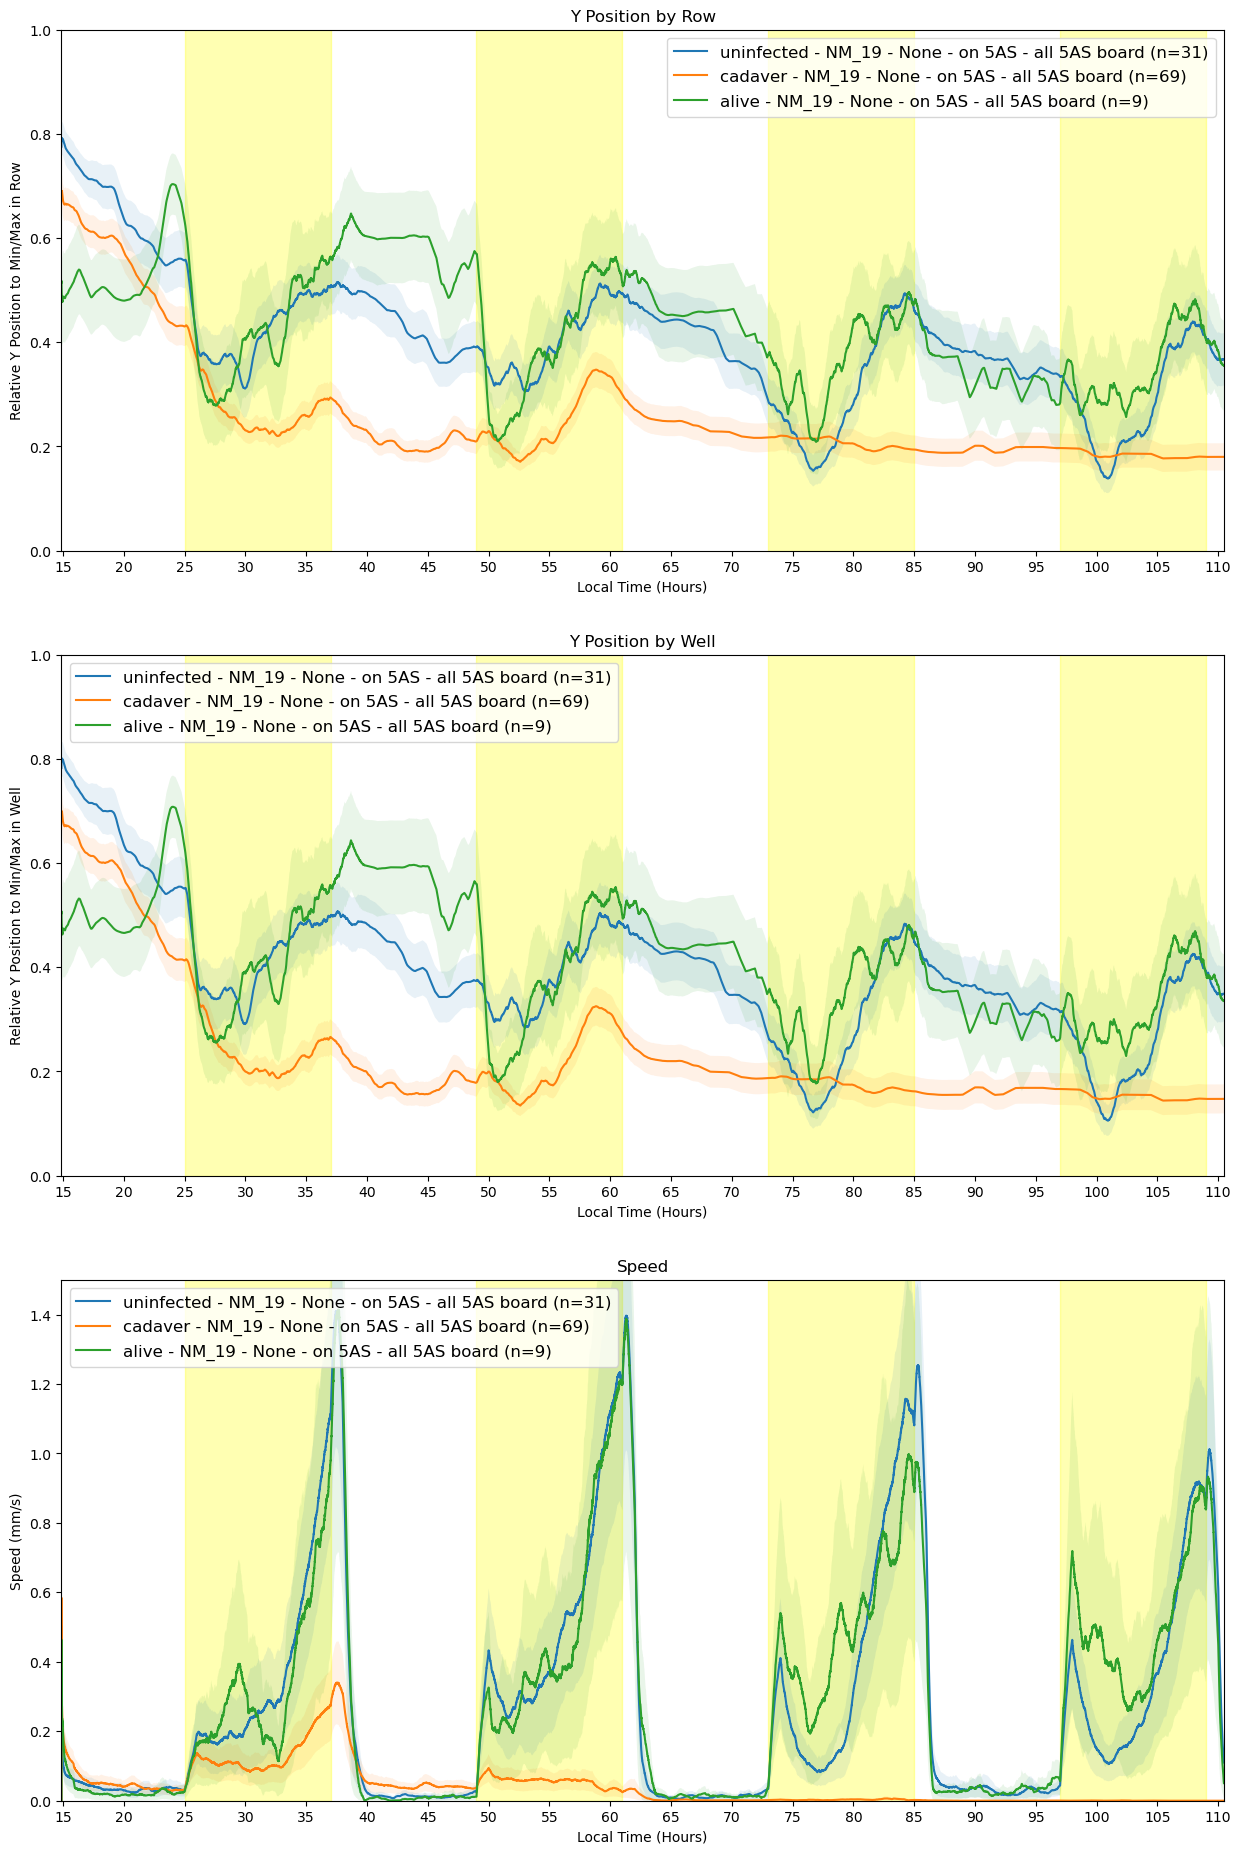

In [48]:
# PLOT WITH MULTIPLE CONDITIONS
if sum_classic == 0:
    # define figure and axes
    fig, axs = plt.subplots(3, 1, figsize=(15, 23))

    # define the light cycle
    lights_on = []
    for i in range(-1, 1 + int(np.ceil((len(speed_reduced.values[0])) / (3 * 60 * 60) / 24))):  # days of the trial
        lights_on.append(ZT0 + 24 * i)
        lights_on.append(ZT0 + ontime + 24 * i)

    # fill light cycle in the plots
    for i in range(0, len(lights_on), 2):
        if i + 1 < len(lights_on):
            for ax in axs:
                ax.fill_betweenx((0, 4), lights_on[i], lights_on[i + 1], color='yellow', alpha=0.3)

    # plot data for ypos by row
    plot_data(axs[0], results_ypos_row, plot_thresh)
    axs[0].set_ylabel("Relative Y Position to Min/Max in Row")
    axs[0].set_title("Y Position by Row")
    axs[0].set_xlabel("Local Time (Hours)")
    axs[0].set_xticks(np.arange(0, np.ceil((len(ypos_row_reduced.values[0])) / (3 * 60 * 60) + start_time_hr), 5))
    axs[0].legend(prop={"size": 12}, loc="upper right")
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(start_time_hr, (len(ypos_row_reduced.values[0])) / (3 * 60 * 60) + start_time_hr)

    # plot data for ypos by well
    plot_data(axs[1], results_ypos_well, plot_thresh)
    axs[1].set_ylabel("Relative Y Position to Min/Max in Well")
    axs[1].set_xlabel("Local Time (Hours)")
    axs[1].set_title("Y Position by Well")
    axs[1].set_xticks(np.arange(0, np.ceil((len(ypos_well_reduced.values[0])) / (3 * 60 * 60) + start_time_hr), 5))
    axs[1].legend(prop={"size": 12}, loc="upper left")
    axs[1].set_ylim(0, 1)
    axs[1].set_xlim(start_time_hr, (len(ypos_well_reduced.values[0])) / (3 * 60 * 60) + start_time_hr)

    # plot data for speed
    plot_data(axs[2], results_speed, plot_thresh)
    axs[2].set_ylabel("Speed (mm/s)")
    axs[2].set_title("Speed")
    axs[2].set_xlabel("Local Time (Hours)")
    axs[2].set_xticks(np.arange(0, np.ceil((len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr), 5))
    axs[2].legend(prop={"size": 12}, loc="upper left")
    axs[2].set_ylim(0, 1.5)
    axs[2].set_xlim(start_time_hr, (len(speed_reduced.values[0])) / (3 * 60 * 60) + start_time_hr)

    plt.show()


# Make cadaver graph

In [49]:
# function to align cadaver data by TOD and living flies by mock TOD 
def align(metric_reduced, TODs_reduced, infecto, prim_cond, sec_cond):
    # Initialize dictionary to store the results
    results = {}

    # Define groups based on infecto
    if infecto == 1:
        groups = {
            'uninfected': TODs_reduced['Rx'] == 'Uninfected',
            'cadaver': (TODs_reduced['Status'] == 0) & (TODs_reduced['Rx'] != 'Uninfected'),
            'alive': (TODs_reduced['Status'] == 1)  & (TODs_reduced['Rx'] != 'Uninfected')
        }
    else:
        groups = {'all': np.ones(len(TODs_reduced), dtype=bool)}  # No separation by group, use all data

    # Predefine cadaver data for reference
    cadavers_only_metric = metric_reduced[(TODs_reduced['Status'] == 0) & (TODs_reduced['Rx'] != 'Uninfected')].reset_index(drop=True)
    cadavers_only_TODs = TODs_reduced[(TODs_reduced['Status'] == 0) & (TODs_reduced['Rx'] != 'Uninfected')].reset_index(drop=True)
    
    # Determine the maximum number of columns needed in the result frame based on cadaver data
    if len(cadavers_only_TODs) > 0:
        columns_range = range(max(int(tod) + 1 for tod in cadavers_only_TODs["Blind_TOD"]) - 1, -1, -1)
        max_columns = max(cadavers_only_metric.columns.get_loc(round(tod)) + 1 for tod in cadavers_only_TODs["Blind_TOD"])
    else:
        columns_range = range(0)
        max_columns = 0

    # Loop through each group
    for group_name, group_mask in groups.items():
        # Initialize a dictionary for the current group
        results[group_name] = {}

        # Further group by Geno
        geno_types = TODs_reduced['Geno'].unique()

        for geno in geno_types:
            geno_mask = TODs_reduced['Geno'] == geno

            # Initialize dictionary for the current Geno group
            results[group_name][geno] = {}
            
            # Further group by sex
            if sex_seg == 1:
                sexes = TODs_reduced['Sex'].unique()
            else:
                sexes = [None]  # no separation by secondary condition, use all data

            for sex in sexes:
                if sex is not None:
                    sex_mask = TODs_reduced['Sex'] == sex
                else:
                    sex_mask = {'all sexes': np.ones(len(TODs_reduced), dtype=bool)}  # No separation by sex

                if prim_cond == 1:
                    conditions = TODs_reduced['Condition'].unique()
                else:
                    conditions = [None]  # No separation by primary condition, use all data

                # Initialize dictionary for the current sex group
                results[group_name][geno][sex] = {}

                # Loop through each condition
                for condition in conditions:
                    if condition is not None:
                        condition_mask = TODs_reduced['Condition'] == condition
                    else:
                        condition_mask = np.ones(len(TODs_reduced), dtype=bool)  # No separation by condition

                    if sec_cond == 1:
                        secondary_conditions = TODs_reduced['Condition_alt'].unique()
                    else:
                        secondary_conditions = [None]  # No separation by secondary condition, use all data

                    results[group_name][geno][sex][condition] = {}

                    # Loop through each secondary condition
                    for sec_condition in secondary_conditions:
                        if sec_condition is not None:
                            sec_condition_mask = TODs_reduced['Condition_alt'] == sec_condition
                        else:
                            sec_condition_mask = np.ones(len(TODs_reduced), dtype=bool)  # No separation by secondary condition

                        # Combine masks to filter data
                        combined_mask = group_mask & geno_mask & sex_mask & condition_mask & sec_condition_mask

                        # Create a new DataFrame to store the aligned results
                        #result_df = pd.DataFrame(columns=range(max_columns-1, -1, -1))
                        result_df = []

                        if group_name == 'uninfected' or group_name == 'alive':
                            data_metric = metric_reduced[combined_mask]
                            data_metric = data_metric.values
                            data_TODs = TODs_reduced[combined_mask]

                            # Align live data based on mock TODs
                            random.seed(10)  # Set seed for reproducibility
                            for index, ROI in enumerate(data_TODs["ROI"]):
                                if max_columns > 0:
                                    tod_index = cadavers_only_metric.columns.get_loc(random.choice(list(TODs_reduced["Blind_TOD"].nlargest(2))))
                                    individual_metric = data_metric[index, :tod_index + 1]
                                    reversed_metric = individual_metric[::-1]
                                    result_series = pd.Series(reversed_metric, index=range(tod_index+1))
                                    padded_metric = np.pad(reversed_metric, (0, max(int(tod) + 1 for tod in cadavers_only_TODs["Blind_TOD"]) - len(reversed_metric)), 'constant', constant_values=np.nan)
                                    rereversed_metric = padded_metric[::-1]
                                    result_df.append(rereversed_metric)
                                    #result_df.loc[len(cadavers_only_TODs) + index] = result_series

                        if group_name == 'cadaver':
                            data_metric = metric_reduced[combined_mask]
                            data_metric = data_metric.values
                            data_TODs = TODs_reduced[combined_mask]

                            # Align cadaver data using predefined cadavers_only_metric and cadavers_only_TODs
                            for index, tod in enumerate(data_TODs["Blind_TOD"]):
                                tod_index = int(tod)
                                individual_metric = data_metric[index, :tod_index + 1]
                                reversed_metric = individual_metric[::-1]
                                padded_metric = np.pad(reversed_metric, (0, max(int(tod) + 1 for tod in cadavers_only_TODs["Blind_TOD"]) - len(reversed_metric)), 'constant', constant_values=np.nan)
                                rereversed_metric = padded_metric[::-1]
                                result_df.append(rereversed_metric)
                        
                        if len(result_df) > 0:
                            result_array = np.vstack(result_df)
                            result_df = pd.DataFrame(result_array, columns=columns_range)
                        else:
                            result_df = pd.DataFrame()

                        # Store the aligned DataFrame for the current combination
                        results[group_name][geno][sex][condition][sec_condition] = result_df

    return results


In [50]:
# use the alignment code
aligned_speed = align(speed_reduced, TODs_reduced_all_comp, infecto, prim_cond, sec_cond)
aligned_ypos_well = align(ypos_well_reduced, TODs_reduced_all_comp, infecto, prim_cond, sec_cond)
aligned_ypos_row = align(ypos_row_reduced, TODs_reduced_all_comp, infecto, prim_cond, sec_cond)

In [51]:
def cad_graph_metrics(aligned_data, TODs_reduced, infecto, prim_cond, sec_cond):

    # initialize dictionary to store the results
    results = {}

    # define the groups if there was an infection
    if infecto == 1:
        groups = {
            'uninfected': TODs_reduced['Rx'] == 'Uninfected',
            'cadaver': (TODs_reduced['Status'] == 0) & (TODs_reduced['Rx'] != 'Uninfected'),
            'alive': (TODs_reduced['Status'] == 1) & (TODs_reduced['Rx'] != 'Uninfected')
        }
    else:
        groups = {'all': np.ones(len(TODs_reduced), dtype=bool)}  # No separation by group, use all data

    # get unique conditions and secondary conditions, if needed
    genotypes = TODs_reduced['Geno'].unique()
    
    if sex_seg == 1:
        sexes = TODs_reduced['Sex'].unique()
    else:
        sexes = [None]  # no separation by secondary condition, use all data

    if prim_cond == 1:
        conditions = TODs_reduced['Condition'].unique()
    else:
        conditions = [None]  # no separation by primary condition, use all data

    if sec_cond == 1:
        secondary_conditions = TODs_reduced['Condition_alt'].unique()
    else:
        secondary_conditions = [None]  # no separation by secondary condition, use all data

    # loop through each group
    for group_name, group_mask in groups.items():
        # initialize a dictionary for the current group
        results[group_name] = {}

        # loop through each genotype
        for genotype in genotypes:
            if genotype is not None:
                genotype_mask = TODs_reduced['Geno'] == genotype
            else:
                genotype_mask = np.ones(len(TODs_reduced), dtype=bool)  # No separation by genotype
            
            results[group_name][genotype] = {}
            
            # loop through each sex
            for sex in sexes:
                if sex is not None:
                    sex_mask = TODs_reduced['Sex'] == sex
                else:
                    sex_mask = {'all sexes': np.ones(len(TODs_reduced), dtype=bool)}  # No separation by sex

                results[group_name][genotype][sex] = {}
            
                # loop through each condition
                for condition in conditions:
                    if condition is not None:
                        condition_mask = TODs_reduced['Condition'] == condition
                    else:
                        condition_mask = np.ones(len(TODs_reduced), dtype=bool)  # No separation by condition

                    if prim_cond == 1:
                        results[group_name][genotype][sex][condition] = {}
                    else:
                        results[group_name][genotype][sex] = {}

                    # loop through each secondary condition
                    for sec_condition in secondary_conditions:
                        if sec_condition is not None:
                            sec_condition_mask = TODs_reduced['Condition_alt'] == sec_condition
                        else:
                            sec_condition_mask = np.ones(len(TODs_reduced), dtype=bool)  # No separation by secondary condition


                        # store results based on the separation level
                        if prim_cond == 1 and sec_cond == 1:
                            # pull out relevant data
                            array_value = np.array(aligned_data[group_name][genotype][sex][condition][sec_condition])

                            if len(array_value) > 0:
                                # calculate metrics
                                dist, sem, lower_bound, upper_bound = calculate_metrics(array_value,0.31*3, 0)
                            else:
                                dist, sem, lower_bound, upper_bound = np.nan,np.nan,np.nan,np.nan

                            # save metrics
                            results[group_name][genotype][sex][condition][sec_condition] = {
                                'data': array_value,
                                'dist': dist,
                                'sem': sem,
                                'lower_bounds': lower_bound,
                                'upper_bounds': upper_bound
                            }
                        elif prim_cond == 1:
                            # pull out relevant data
                            array_value = np.array(aligned_data[group_name][genotype][sex][condition][None])

                            if len(array_value) > 0:
                                # calculate metrics
                                dist, sem, lower_bound, upper_bound = calculate_metrics(array_value,0.31*3, 0)
                            else:
                                dist, sem, lower_bound, upper_bound = np.nan,np.nan,np.nan,np.nan

                            # save metrics
                            results[group_name][genotype][sex][condition] = {
                                'data': array_value,
                                'dist': dist,
                                'sem': sem,
                                'lower_bounds': lower_bound,
                                'upper_bounds': upper_bound
                            }
                        else:
                            # pull out relevant data
                            array_value = np.array(aligned_data[group_name][genotype][sex][None][None])

                            if len(array_value) > 0:
                                # calculate metrics
                                dist, sem, lower_bound, upper_bound = calculate_metrics(array_value,0.31*3, 0)
                            else:
                                dist, sem, lower_bound, upper_bound = np.nan,np.nan,np.nan,np.nan

                            # save metrics
                            results[group_name][genotype][sex] = {
                                'data': array_value,
                                'dist': dist,
                                'sem': sem,
                                'lower_bounds': lower_bound,
                                'upper_bounds': upper_bound
                            }

        # return the dictionary containing all results
    return results       

In [52]:
# calculate metrics for the graphs
speed_graph_metrics = cad_graph_metrics(aligned_speed, TODs_reduced, infecto, prim_cond, sec_cond)
ypos_well_graph_metrics = cad_graph_metrics(aligned_ypos_well, TODs_reduced, infecto, prim_cond, sec_cond)
ypos_row_graph_metrics = cad_graph_metrics(aligned_ypos_row, TODs_reduced, infecto, prim_cond, sec_cond)

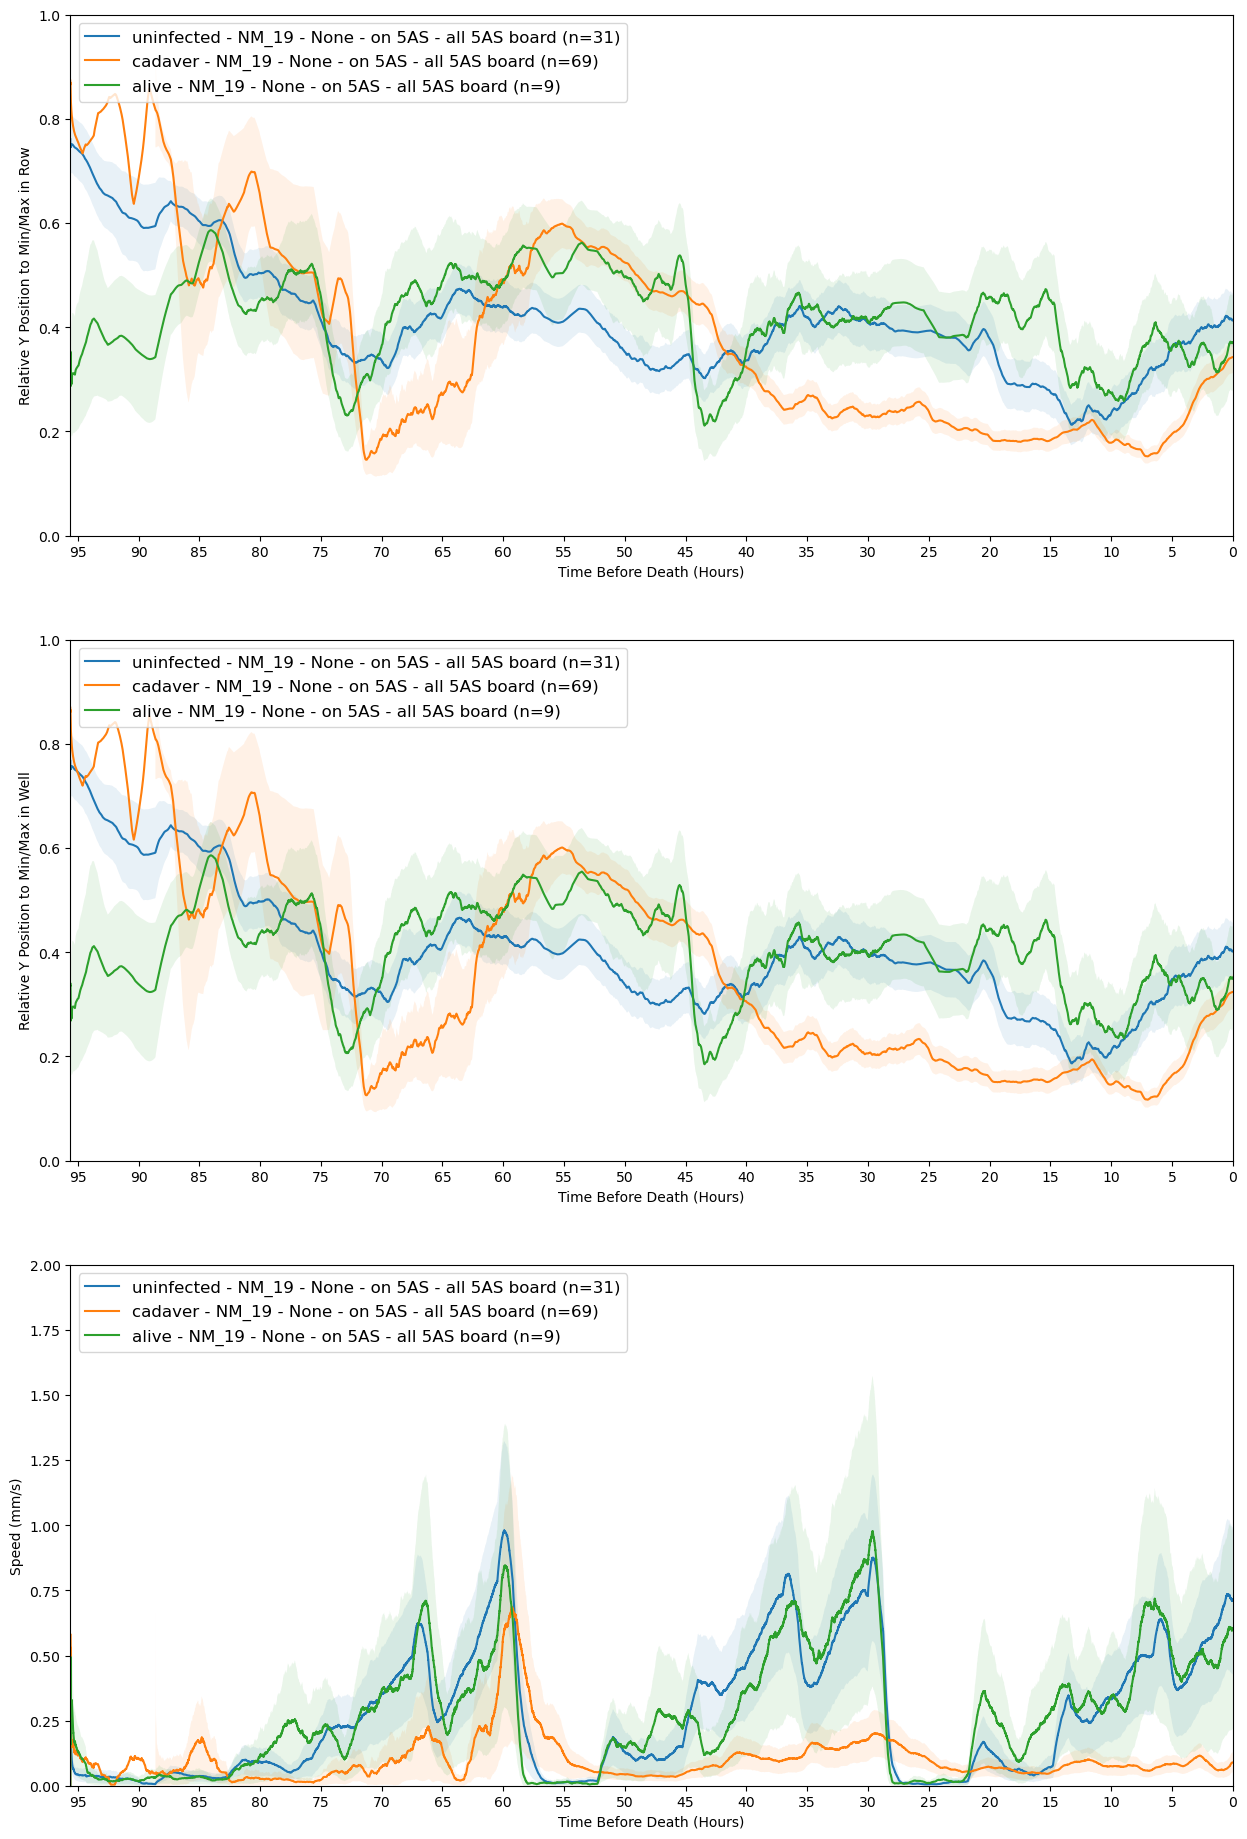

In [53]:
# Plotting function to handle different separation levels
def plot_data(ax, results, plot_thresh):
    for group_name, group_data in results.items():
        for geno_name, geno_data in group_data.items():   
            for sex_name, sex_data in geno_data.items():
                if list(results[group_name][geno_name][sex_name].keys())[0] != 'data': 
                    for condition, cond_data in sex_data.items():
                        if list(results[group_name][geno_name][sex_name][condition].keys())[0] != 'data':
                            for sec_condition, sec_data in cond_data.items():
                                if plot_thresh <= len(sec_data['data']):
                                    # plot each separation level
                                    time_array = np.flip(np.linspace(0, (len(speed_reduced.values[0])) / (3 * 60 * 60) + 0, len(results[group_name][geno_name][sex_name][condition][sec_condition]['dist'])))
                                    ax.plot(time_array, sec_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - {condition} - {sec_condition} (n={len(sec_data["data"])})')
                                    ax.fill_between(time_array, np.array(sec_data['lower_bounds']).ravel(), np.array(sec_data['upper_bounds']).ravel(), alpha=0.1)
                        else:
                            if plot_thresh <= len(cond_data['data']):
                                # if no secondary condition, just use condition
                                time_array = np.flip(np.linspace(0, (len(speed_reduced.values[0])) / (3 * 60 * 60) + 0, len(results[group_name][geno_name][sex_name][condition]['dist'])))
                                ax.plot(time_array, cond_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - {condition} (n={len(cond_data["data"])})')
                                ax.fill_between(time_array, np.array(cond_data['lower_bounds']).ravel(), np.array(cond_data['upper_bounds']).ravel(), alpha=0.1)
                else:
                    if plot_thresh <= len(sex_data['data']):
                        # if no primary or secondary conditions, just use infection outcome
                        time_array = np.flip(np.linspace(0, (len(speed_reduced.values[0])) / (3 * 60 * 60) + 0, len(results[group_name][geno_name][sex_name]['dist'])))
                        ax.plot(time_array, sex_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - (n={len(sex_data["data"])})')
                        ax.fill_between(time_array, np.array(sex_data['lower_bounds']).ravel(), np.array(sex_data['upper_bounds']).ravel(), alpha=0.1)

# Set up the plot
fig, axs = plt.subplots(3, 1, figsize=(15, 23))

# Plot data for each subplot
plot_data(axs[0], ypos_row_graph_metrics, plot_thresh)
axs[0].set_ylabel("Relative Y Position to Min/Max in Row")
axs[0].set_xlabel("Time Before Death (Hours)")
axs[0].set_xticks(np.arange(0, np.ceil((len(speed_reduced.values[0]))/(3*60*60)+0), 5))
axs[0].legend(prop={"size": 12}, loc="upper left")
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, (len(speed_reduced.values[0]))/(3*60*60)+0)
axs[0].invert_xaxis()

plot_data(axs[1], ypos_well_graph_metrics, plot_thresh)
axs[1].set_ylabel("Relative Y Position to Min/Max in Well")
axs[1].set_xlabel("Time Before Death (Hours)")
axs[1].set_xticks(np.arange(0, np.ceil((len(speed_reduced.values[0]))/(3*60*60)), 5))
axs[1].legend(prop={"size": 12}, loc="upper left")
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, (len(speed_reduced.values[0]))/(3*60*60)+0)
axs[1].invert_xaxis()

plot_data(axs[2], speed_graph_metrics, plot_thresh)
axs[2].set_ylabel("Speed (mm/s)")
axs[2].set_xlabel("Time Before Death (Hours)")
axs[2].set_xticks(np.arange(0, np.ceil((len(speed_reduced.values[0]))/(3*60*60)), 5))
axs[2].legend(prop={"size": 12}, loc="upper left")
axs[2].set_ylim(0, 2)
axs[2].set_xlim(0, (len(speed_reduced.values[0]))/(3*60*60)+0)
axs[2].invert_xaxis()

plt.show()


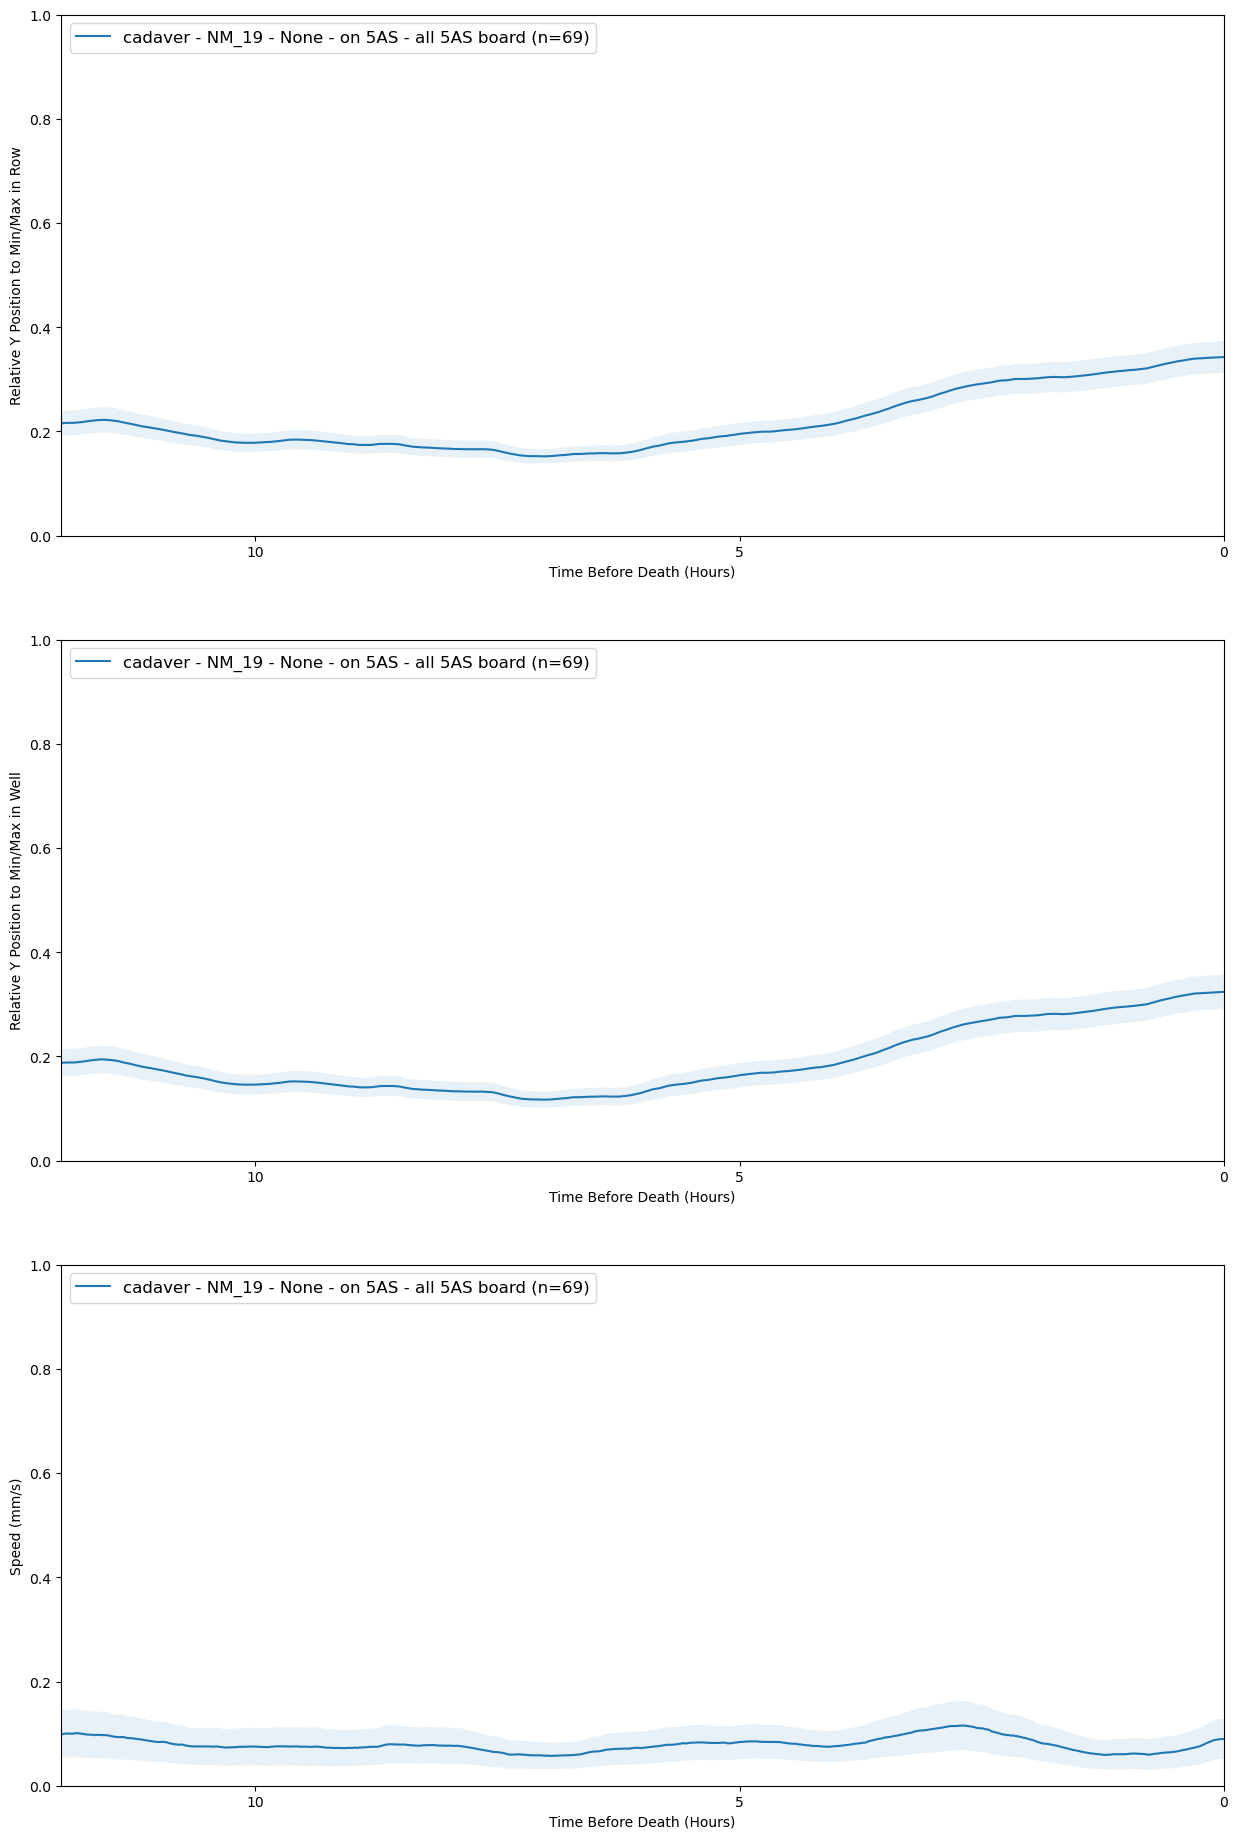

In [54]:
# Plot again, but with just the last 12 hours and cadavers only
def plot_data(ax, results, plot_thresh):
    for group_name, group_data in results.items():
        for geno_name, geno_data in group_data.items():   
            for sex_name, sex_data in geno_data.items():
                if list(results[group_name][geno_name][sex_name].keys())[0] != 'data': 
                    for condition, cond_data in sex_data.items():
                        if list(results[group_name][geno_name][sex_name][condition].keys())[0] != 'data':
                            for sec_condition, sec_data in cond_data.items():
                                if plot_thresh <= len(sec_data['data']) and group_name == 'cadaver':
                                    # plot each separation level
                                    time_array = np.flip(np.linspace(0, (len(speed_reduced.values[0])) / (3 * 60 * 60) + 0, len(results[group_name][geno_name][sex_name][condition][sec_condition]['dist'])))
                                    ax.plot(time_array, sec_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - {condition} - {sec_condition} (n={len(sec_data["data"])})')
                                    ax.fill_between(time_array, np.array(sec_data['lower_bounds']).ravel(), np.array(sec_data['upper_bounds']).ravel(), alpha=0.1)
                        else:
                            if plot_thresh <= len(cond_data['data']) and group_name == 'cadaver':
                                # if no secondary condition, just use condition
                                time_array = np.flip(np.linspace(0, (len(speed_reduced.values[0])) / (3 * 60 * 60) + 0, len(results[group_name][geno_name][sex_name][condition]['dist'])))
                                ax.plot(time_array, cond_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - {condition} (n={len(cond_data["data"])})')
                                ax.fill_between(time_array, np.array(cond_data['lower_bounds']).ravel(), np.array(cond_data['upper_bounds']).ravel(), alpha=0.1)
                else:
                    if plot_thresh <= len(sex_data['data']) and group_name == 'cadaver':
                        # if no primary or secondary conditions, just use infection outcome
                        time_array = np.flip(np.linspace(0, (len(speed_reduced.values[0])) / (3 * 60 * 60) + 0, len(results[group_name][geno_name][sex_name]['dist'])))
                        ax.plot(time_array, sex_data['dist'], label=f'{group_name} - {geno_name} - {sex_name} - (n={len(sex_data["data"])})')
                        ax.fill_between(time_array, np.array(sex_data['lower_bounds']).ravel(), np.array(sex_data['upper_bounds']).ravel(), alpha=0.1)

# Set up the plot
fig, axs = plt.subplots(3, 1, figsize=(15, 23))

# Plot data for each subplot
plot_data(axs[0], ypos_row_graph_metrics, plot_thresh)
axs[0].set_ylabel("Relative Y Position to Min/Max in Row")
axs[0].set_xlabel("Time Before Death (Hours)")
axs[0].set_xticks(np.arange(0, np.ceil((len(speed_reduced.values[0]))/(3*60*60)+0), 5))
axs[0].legend(prop={"size": 12}, loc="upper left")
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 12)
axs[0].invert_xaxis()

plot_data(axs[1], ypos_well_graph_metrics, plot_thresh)
axs[1].set_ylabel("Relative Y Position to Min/Max in Well")
axs[1].set_xlabel("Time Before Death (Hours)")
axs[1].set_xticks(np.arange(0, np.ceil((len(speed_reduced.values[0]))/(3*60*60)), 5))
axs[1].legend(prop={"size": 12}, loc="upper left")
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 12)
axs[1].invert_xaxis()

plot_data(axs[2], speed_graph_metrics, plot_thresh)
axs[2].set_ylabel("Speed (mm/s)")
axs[2].set_xlabel("Time Before Death (Hours)")
axs[2].set_xticks(np.arange(0, np.ceil((len(speed_reduced.values[0]))/(3*60*60)), 5))
axs[2].legend(prop={"size": 12}, loc="upper left")
axs[2].set_ylim(0, 1)
axs[2].set_xlim(0, 12)
axs[2].invert_xaxis()

plt.show()